In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# toy datasest

In [2]:
input_size = 1
output_size = 1
num_epochs = 100
learning_rate = 0.001

In [3]:
# toy dataset: 15 samples, 1 feature
x_train = np.array([3.3, 4.4, 5.5, 6.71, 6.93, 4.168, 9.779, 6.182, 7.59, 2.167,
                    7.042, 10.791, 5.313, 7.997, 3.1], dtype=np.float32)
y_train = np.array([1.7, 2.76, 2.09, 3.19, 1.694, 1.573, 3.366, 2.596, 2.53, 1.221,
                    2.827, 3.465, 1.65, 2.904, 1.3], dtype=np.float32)

In [4]:
# nn.Linearへの入力は (num_sample, *, num_features) 
# *には任意の次元を追加できる, なくてもよい
x_train = x_train.reshape(15, 1)
y_train = y_train.reshape(15, 1)

In [5]:
# linear regression model
## nn.Module を継承
## __init__() に層オブジェクトを定義
## forward() に順方向の処理

class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        out = self.linear(x)
        return out
    
model = LinearRegression(input_size, output_size)
print(model)

LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [6]:
# loss function
## 線形回帰なのでMSE
criterion = nn.MSELoss()
print(criterion)

# optimizer
## 引数にモデルのパラメータを与える
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
print(optimizer)

MSELoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [7]:
# train the model
for epoch in range(num_epochs):
    # x, yをndarrayからtorch.Tensorに変換
    inputs = torch.from_numpy(x_train)
    targets = torch.from_numpy(y_train)
    
    # パラメータ更新
    optimizer.zero_grad()  # 更新毎に勾配をクリアする
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()  # パラメータ更新
    
    if (epoch+1) % 10 == 0:
        print('Epoch {}/{}, Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch 10/100, Loss: 0.7857
Epoch 20/100, Loss: 0.4306
Epoch 30/100, Loss: 0.3715
Epoch 40/100, Loss: 0.3610
Epoch 50/100, Loss: 0.3584
Epoch 60/100, Loss: 0.3572
Epoch 70/100, Loss: 0.3562
Epoch 80/100, Loss: 0.3552
Epoch 90/100, Loss: 0.3543
Epoch 100/100, Loss: 0.3533


In [8]:
# save the model
torch.save(model.state_dict(), 'model.pkl')

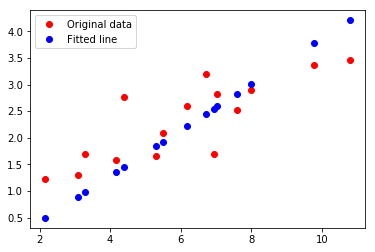

In [9]:
# plot
## gradを持っているTensorはdetach()しないとndarrayに変換できない
predicted = model(torch.from_numpy(x_train)).detach().numpy()
plt.plot(x_train, y_train, 'ro', label='Original data')
plt.plot(x_train, predicted, 'bo', label='Fitted line')
plt.legend()
plt.show()

# Boston house price dataset

13個の特徴量をもとに家の値段を予測

In [10]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:
input_size = 13
output_size = 1
num_epochs = 5000
learning_rate = 0.01

In [12]:
boston = load_boston()
X = boston.data
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)

In [13]:
print(X.shape, y.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(506, 13) (506,)
(339, 13) (167, 13) (339,) (167,)


In [14]:
# normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshape
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

In [15]:
# linear regression model
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        out = self.linear(x)
        return out
    
model = LinearRegression(input_size, output_size)

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
def train(X_train, y_train):
    inputs = torch.from_numpy(X_train).float()
    targets = torch.from_numpy(y_train).float()
    
    optimizer.zero_grad()
    outputs = model(inputs)
    
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [18]:
def valid(X_test, y_test):
    inputs = torch.from_numpy(X_test).float()
    targets = torch.from_numpy(y_test).float()
    
    outputs = model(inputs)
    val_loss = criterion(outputs, targets)
    
    return val_loss.item()

In [19]:
# train the model
loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    # data shuffle
    perm = np.arange(X_train.shape[0])
    np.random.shuffle(perm)
    X_train = X_train[perm]
    y_train = y_train[perm]
    
    loss = train(X_train, y_train)
    val_loss = valid(X_test, y_test)
    
    if (epoch+1) % 200 == 0:
        print('epoch {}, loss: {:.4f}, val_loss: {:.4f}'.format(epoch+1, loss, val_loss))
    
    loss_list.append(loss)
    val_loss_list.append(val_loss)

epoch 200, loss: 445.4966, val_loss: 471.3588
epoch 400, loss: 365.2315, val_loss: 393.6731
epoch 600, loss: 300.6563, val_loss: 329.3096
epoch 800, loss: 246.2130, val_loss: 273.5523
epoch 1000, loss: 200.0640, val_loss: 225.6331
epoch 1200, loss: 161.2536, val_loss: 185.0681
epoch 1400, loss: 128.9850, val_loss: 151.1400
epoch 1600, loss: 102.5162, val_loss: 123.0947
epoch 1800, loss: 81.1444, val_loss: 100.2218
epoch 2000, loss: 64.2028, val_loss: 81.8576
epoch 2200, loss: 51.0575, val_loss: 67.3784
epoch 2400, loss: 41.1092, val_loss: 56.1973
epoch 2600, loss: 33.7958, val_loss: 47.7637
epoch 2800, loss: 28.5973, val_loss: 41.5669
epoch 3000, loss: 25.0432, val_loss: 37.1417
epoch 3200, loss: 22.7198, val_loss: 34.0759
epoch 3400, loss: 21.2768, val_loss: 32.0168
epoch 3600, loss: 20.4313, val_loss: 30.6749
epoch 3800, loss: 19.9677, val_loss: 29.8242
epoch 4000, loss: 19.7316, val_loss: 29.2976
epoch 4200, loss: 19.6210, val_loss: 28.9777
epoch 4400, loss: 19.5737, val_loss: 28.78

In [20]:
num_epochs

5000

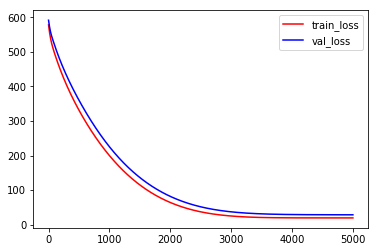

In [21]:
# plot
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()